# Mixture of LLMs mimicing Mixture of Experts

### This notebook implements a Mixture of LLMs (Large Language Models) system using Groq's API.

The core idea is to create a specialized routing system that directs different types of queries to the most appropriate expert language model, similar to how MOEs work as explained in the theory class.
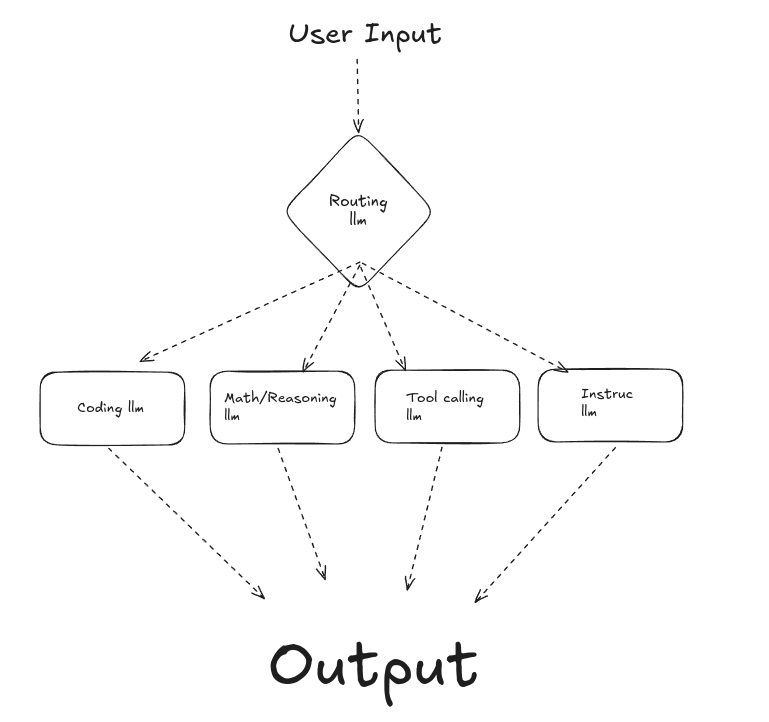

## Setup Libraries


This cell sets up our development environment. We install and import the necessary libraries: groq for API interactions, typing for type hints, and dotenv for secure environment variable management. Type hints help make our code more maintainable and self-documenting.

In [ ]:
# Install required packages
!pip install groq

# Import necessary libraries
import groq
from typing import Dict, List, Tuple
import os
# from dotenv import load_dotenv

## System Overview
The system consists of three main components:

- A router that analyzes and categorizes incoming prompts
- A set of expert models specialized for different tasks
- A coordination layer that manages the flow of information


Here we establish our system's configuration.

The MODEL_CONFIG dictionary maps different task categories to specific models. Currently, we're using Mixtral-8x7b for all categories, but in a production system, you might use different llms for different tasks.


The configuration is centralized, making it easy to modify model assignments.

In [ ]:
# Initialize Groq client
GROQ_API_KEY = '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'
groq_client = groq.Groq(api_key=GROQ_API_KEY)

# Define available models for different tasks
MODEL_CONFIG = {
    "coding": "mixtral-8x7b-32768",    # Best for code generation
    "math": "mixtral-8x7b-32768",      # Strong at mathematical reasoning
    "reasoning": "mixtral-8x7b-32768",  # General reasoning tasks
    "tool_use": "mixtral-8x7b-32768"   # API/tool interactions
}

The router is our system's traffic director. It analyzes incoming prompts using a specialized prompt template and determines which expert should handle the request. The function returns both the category and the corresponding model name.

In [ ]:
def route_prompt(prompt: str, client: groq.Groq) -> Tuple[str, str]:
    """
    Route the incoming prompt to the appropriate expert model.

    Args:
        prompt (str): User's input prompt
        client (groq.Groq): Initialized Groq client

    Returns:
        Tuple[str, str]: (category, model_name)
    """
    routing_prompt = """Analyze this prompt and classify it into exactly one category:
    - coding: Programming, debugging, code explanation
    - math: Mathematical calculations, proofs, equations
    - reasoning: Logical analysis, explanations, general knowledge
    - tool_use: Tasks requiring API calls or external tools

    Return only the category name, nothing else.

    Prompt to analyze: {prompt}
    """

    completion = client.chat.completions.create(
        messages=[{
            "role": "user",
            "content": routing_prompt.format(prompt=prompt)
        }],
        model="mixtral-8x7b-32768",
        temperature=0
    )

    category = completion.choices[0].message.content.strip().lower()
    return category, MODEL_CONFIG[category]

In [ ]:
def get_expert_response(prompt: str, model: str, client: groq.Groq) -> str:
    """
    Get response from the selected expert model.

    Args:
        prompt (str): User's input prompt
        model (str): Selected model name
        client (groq.Groq): Initialized Groq client

    Returns:
        str: Model's response
    """
    completion = client.chat.completions.create(
        messages=[{
            "role": "user",
            "content": prompt
        }],
        model=model,
        temperature=0.7
    )

    return completion.choices[0].message.content

This is our orchestration layer, coordinating the entire process from input to output. It:

- Takes a user prompt
- Routes it to the appropriate expert
- Gets the expert's response
- Returns a structured dictionary with all relevant information

In [ ]:
def process_prompt(prompt: str, client: groq.Groq) -> Dict:
    """
    Main function to process prompts through the expert system.

    Args:
        prompt (str): User's input prompt
        client (groq.Groq): Initialized Groq client

    Returns:
        Dict: Contains category, expert model, and response
    """
    # Route to appropriate expert
    category, expert_model = route_prompt(prompt, client)

    # Get expert response
    response = get_expert_response(prompt, expert_model, client)

    return {
        "category": category,
        "expert_model": expert_model,
        "response": response
    }

In [ ]:
# Example prompts for testing
test_prompts = [
    "Write a Python function to calculate fibonacci numbers",
    "Explain the theory of relativity",
    "Solve the quadratic equation: 2x^2 + 3x - 5 = 0",
    "How to make an API call to Twitter's API?"
]

# Test the system
for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    result = process_prompt(prompt, groq_client)
    print(f"Category: {result['category']}")
    print(f"Model: {result['expert_model']}")
    print(f"Response: {result['response'][:200]}...")  # Show first 200 chars


Prompt: Write a Python function to calculate fibonacci numbers
Category: coding
Model: mixtral-8x7b-32768
Response: Sure, here is a simple Python function that calculates Fibonacci numbers using recursion:
```python
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer."
    elif n == ...

Prompt: Explain the theory of relativity
Category: reasoning
Model: mixtral-8x7b-32768
Response: The theory of relativity is a fundamental concept in physics that was developed by Albert Einstein in the early 20th century. It is actually composed of two separate theories: the special theory of re...

Prompt: Solve the quadratic equation: 2x^2 + 3x - 5 = 0
Category: math
Model: mixtral-8x7b-32768
Response: To solve the quadratic equation 2x^2 + 3x - 5 = 0, we can use the quadratic formula:

x = (-b ± √(b^2 - 4ac)) / 2a

First, identify the values of a, b, and c:
a = 2
b = 3
c = -5

Now, calculate the di...

Prompt: How to make an API call to Twitter's API?
Category: tool